## Part 1: Connect Python IDEs to the SQL server database and perform the analysis. 

In [1]:
import pandas as pd
from sqlalchemy import create_engine

# Replace with your SQL Server credentials
server = 'ASUS'
database = 'medicare'

# Establish connection using SQLAlchemy and Windows Authentication
engine = create_engine(
    f'mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server&trusted_connection=yes')

In [2]:
apc_query = '''
SELECT 
    APC AS Procedure_Code,
    Provider_Id,
    Provider_Name,
    Provider_Street_Address,
    Provider_City,
    Provider_State,
    Provider_Zip_Code,
    Hospital_Referral_Region_HRR_Description AS Region,
    Outpatient_Services AS Volume,
    Average_Estimated_Submitted_Charges AS Avg_Charge,
    Average_Total_Payments As Avg_Payment,
    0 AS Average_Medicare_Payments
    
FROM MEDICARE_PROVIDER_CHARGE_OUTPATIENT_APC30
'''

drg_query = '''
SELECT 
    DRG_Definition AS Procedure_Code,
    Provider_Id,
    Provider_Name,
    Provider_Street_Address,	
    Provider_City,
    Provider_State,
    Provider_Zip_Code,
    Hospital_Referral_Region_HRR_Description AS Region,
    Total_Discharges AS Volume,
    Average_Covered_Charges AS Avg_Charge,
    Average_Total_Payments AS Avg_Payment,
    Average_Medicare_Payments
FROM MEDICARE_PROVIDER_CHARGE_INPATIENT_DRG100
'''

apc_sum_query = '''
SELECT 
    APC AS Procedure_Code,
    Outpatient_Services AS Volume,
    Average_Estimated_Submitted_Charges AS Avg_Charge,
    Average_Total_Payments AS Avg_Payment
FROM MEDICARE_CHARGE_OUTPATIENT_APC30_SUMMARY
'''

drg_sum_query = '''
SELECT 
    DRG_Definition AS Procedure_Code,
    Total_Discharges AS Volume,
    Average_Covered_Charges AS Avg_Charge,
    Average_Total_Payments AS Avg_Payment
FROM MEDICARE_CHARGE_INPATIENT_DRG100_DRG_SUMMARY
'''

tran_query = '''
SELECT 
    *
FROM TRANSACTION_SUMMARY


'''

In [3]:
# Load data into DataFrames 
apc_df = pd.read_sql(apc_query, engine)
drg_df = pd.read_sql(drg_query, engine)
tran_df = pd.read_sql(tran_query, engine)
combined_df = pd.concat([apc_df, drg_df], ignore_index=True)


apc_sum_df = pd.read_sql(apc_query, engine)
drg_sum_df = pd.read_sql(drg_query, engine)
combined_sum_df = pd.concat([apc_sum_df, drg_sum_df], ignore_index=True)


In [4]:
apc_df['Type of Service']='Outpatient'
drg_df['Type of Service']='Inpatient'

In [5]:
combined_df = pd.concat([apc_df, drg_df], ignore_index=True)

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

## Descriptive Statistics

In [7]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206437 entries, 0 to 206436
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Procedure_Code             206437 non-null  object 
 1   Provider_Id                206437 non-null  int64  
 2   Provider_Name              206437 non-null  object 
 3   Provider_Street_Address    206437 non-null  object 
 4   Provider_City              206437 non-null  object 
 5   Provider_State             206437 non-null  object 
 6   Provider_Zip_Code          206437 non-null  int64  
 7   Region                     206437 non-null  object 
 8   Volume                     206437 non-null  int64  
 9   Avg_Charge                 206437 non-null  float64
 10  Avg_Payment                206437 non-null  float64
 11  Average_Medicare_Payments  206437 non-null  float64
 12  Type of Service            206437 non-null  object 
dtypes: float64(3), int64(3), obje

In [8]:
combined_df[['Provider_Id','Provider_Zip_Code']]=combined_df[['Provider_Id','Provider_Zip_Code']].astype('object')

In [9]:
combined_df.describe(include='all')

,Procedure_Code,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Region,Volume,Avg_Charge,Avg_Payment,Average_Medicare_Payments,Type of Service
count,206437,206437.0,206437,206437,206437,206437,206437.0,206437,206437.000000,206437.000000,206437.000000,206437.000000,206437
unique,130,3337.0,3201,3326,1977,51,3053.0,306,NaN,NaN,NaN,NaN,2
top,194 - SIMPLE PNEUMONIA & PLEURISY W CC,220086.0,GOOD SAMARITAN HOSPITAL,100 MEDICAL CENTER DRIVE,CHICAGO,CA,76104.0,CA - Los Angeles,NaN,NaN,NaN,NaN,Inpatient
freq,3023,129.0,749,217,1898,16047,395.0,4378,NaN,NaN,NaN,NaN,163065
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,157.322709,28851.969376,7723.721604,6709.818760,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1520.597924,34224.594003,7823.935513,7360.569892,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,12.643750,7.305000,0.000000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.000000,9364.575195,3867.481445,2864.954590,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.000000,19764.125000,6101.138184,5064.666504,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.000000,36813.855469,9912.400391,8812.583008,NaN


In [10]:
combined_df.isna().sum()

Procedure_Code               0
Provider_Id                  0
Provider_Name                0
Provider_Street_Address      0
Provider_City                0
Provider_State               0
Provider_Zip_Code            0
Region                       0
Volume                       0
Avg_Charge                   0
Avg_Payment                  0
Average_Medicare_Payments    0
Type of Service              0
dtype: int64

In [11]:
combined_df.duplicated().sum()

0

In [12]:
tran_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514809 entries, 0 to 1514808
Data columns (total 6 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1514809 non-null  int64 
 1   N_COUNT         1514809 non-null  int64 
 2   AGE             1507067 non-null  object
 3   GENDER          1514809 non-null  object
 4   INCOME          1507259 non-null  object
 5   global_proc_id  1514809 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 69.3+ MB


In [13]:
tran_df.isna().sum()

ID                   0
N_COUNT              0
AGE               7742
GENDER               0
INCOME            7550
global_proc_id       0
dtype: int64

In [14]:
tran_df.duplicated().sum()

0

In [15]:
tran_df[['ID','global_proc_id']]=tran_df[['ID','global_proc_id']].astype('object')

In [16]:
tran_df.describe(include='all')

,ID,N_COUNT,AGE,GENDER,INCOME,global_proc_id
count,1514809.0,1514809.0,1507067,1514809,1507259,1514809.0
unique,505000.0,NaN,4,2,5,130.0
top,14865469.0,NaN,65-74,F,48000+,26.0
freq,13.0,NaN,665691,831619,351751,291815.0
mean,NaN,1.0,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,NaN
min,NaN,1.0,NaN,NaN,NaN,NaN
25%,NaN,1.0,NaN,NaN,NaN,NaN
50%,NaN,1.0,NaN,NaN,NaN,NaN
75%,NaN,1.0,NaN,NaN,NaN,NaN


In [17]:
tran_df['GENDER'].value_counts(normalize=True) * 100

GENDER
F    54.899265
M    45.100735
Name: proportion, dtype: float64

In [18]:
tran_df['INCOME'].value_counts(normalize=True) * 100

INCOME
48000+         23.337131
<16000         21.630456
16000-23999    20.587570
32000-47999    19.192521
24000-31999    15.252322
Name: proportion, dtype: float64

In [19]:
tran_df['AGE'].value_counts(normalize=True) * 100

AGE
65-74    44.171294
75-84    25.913977
<65      16.969849
85+      12.944879
Name: proportion, dtype: float64

## Data visualization

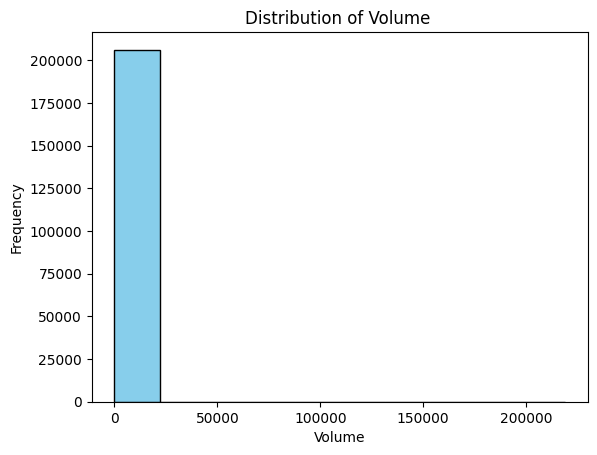

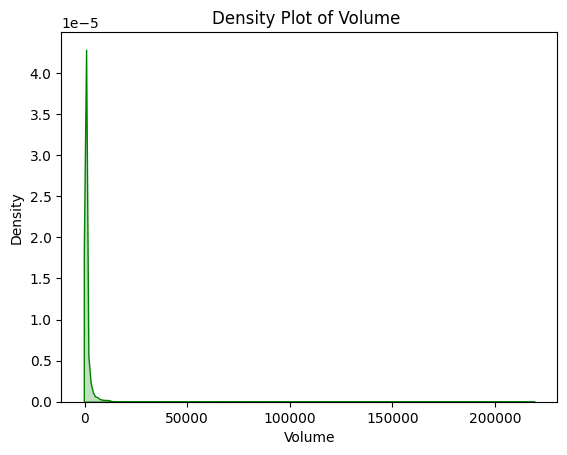

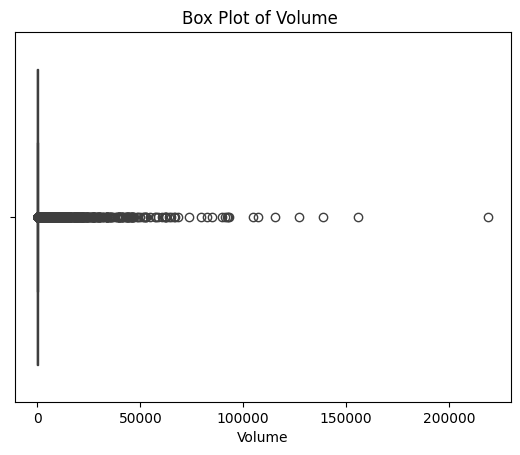

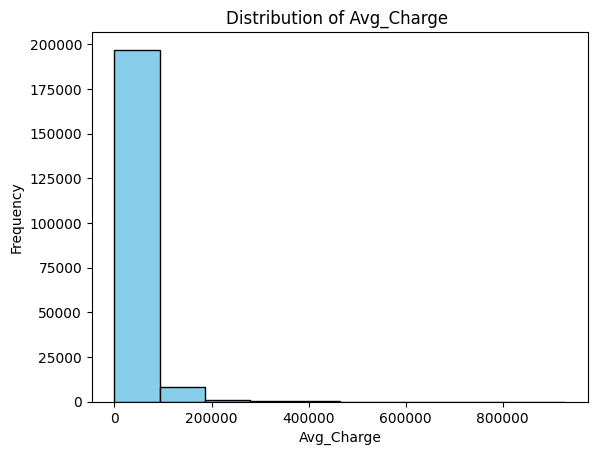

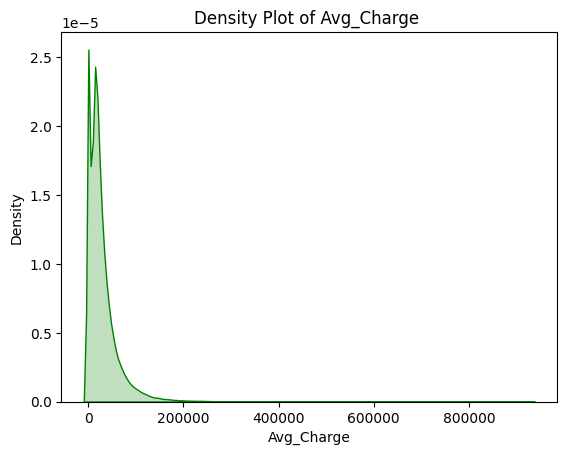

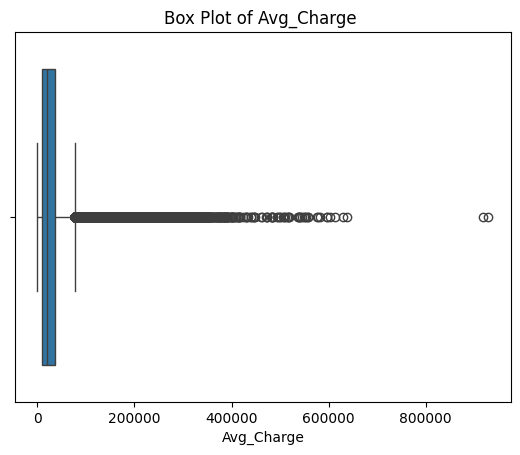

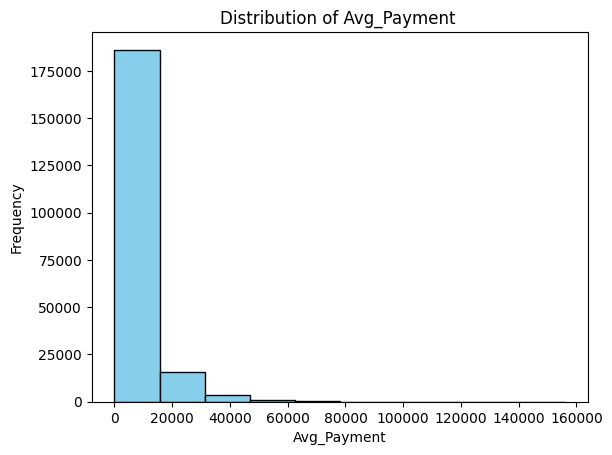

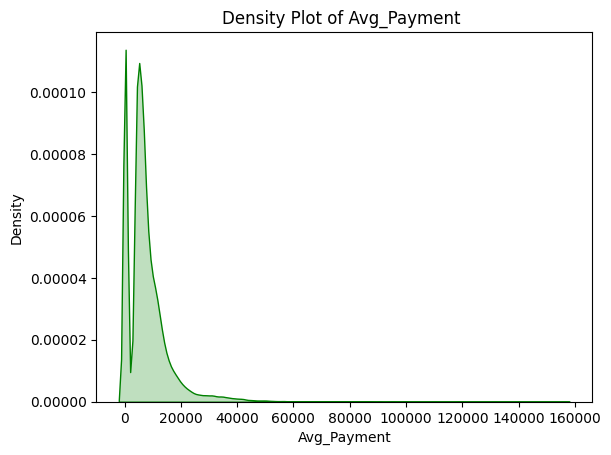

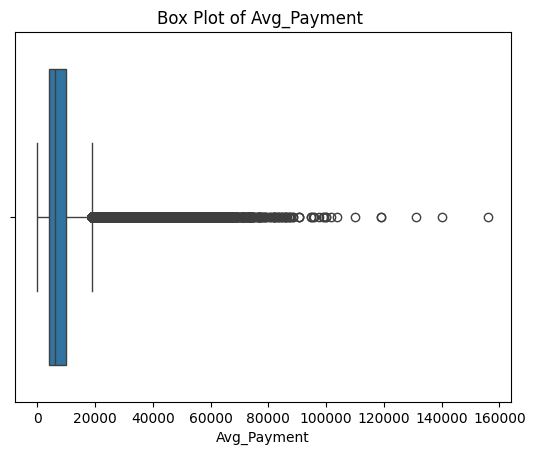

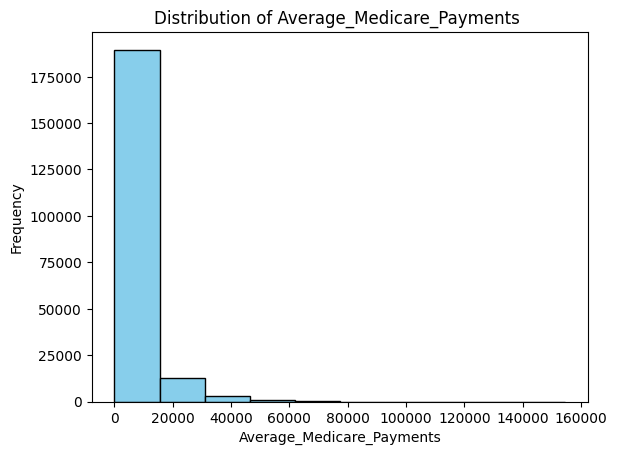

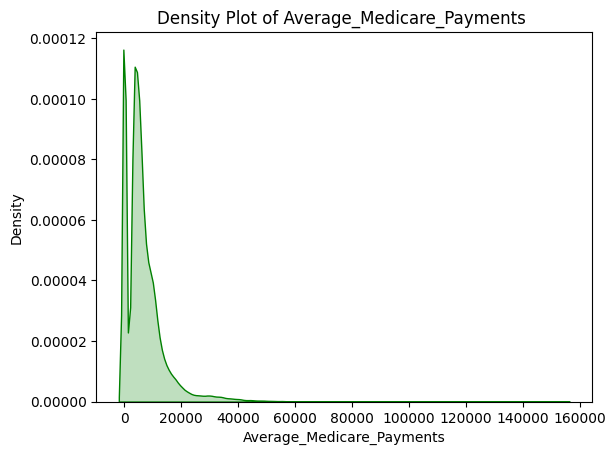

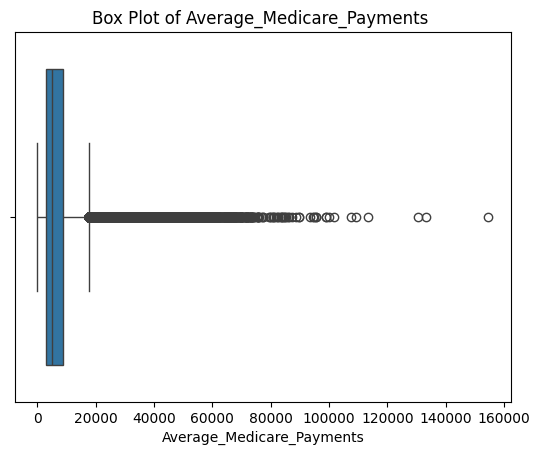

In [20]:
for col in ['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']:
    plt.hist(combined_df[col] ,color='skyblue', edgecolor='black')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {col} ')
    plt.show()
    sns.kdeplot(combined_df[col], fill=True, color='green')
    plt.xlabel(col)
    plt.title(f'Density Plot of {col} ')
    plt.show()
    sns.boxplot(x=combined_df[col])
    plt.xlabel(col)
    plt.title(f'Box Plot of {col} ')
    plt.show()

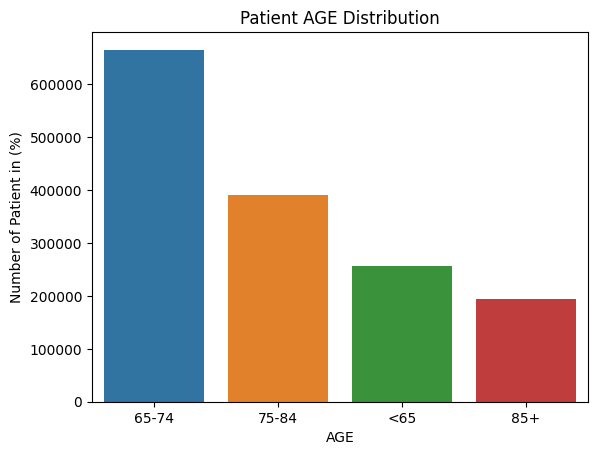

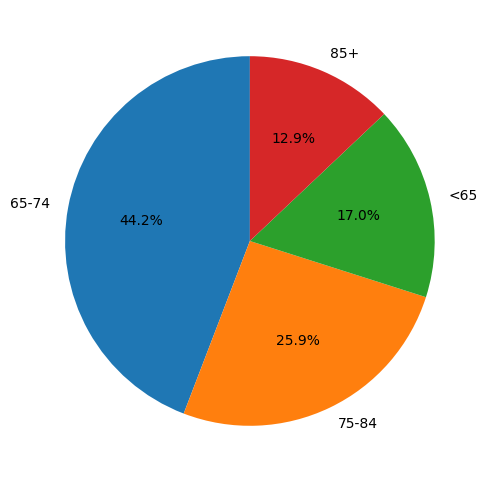

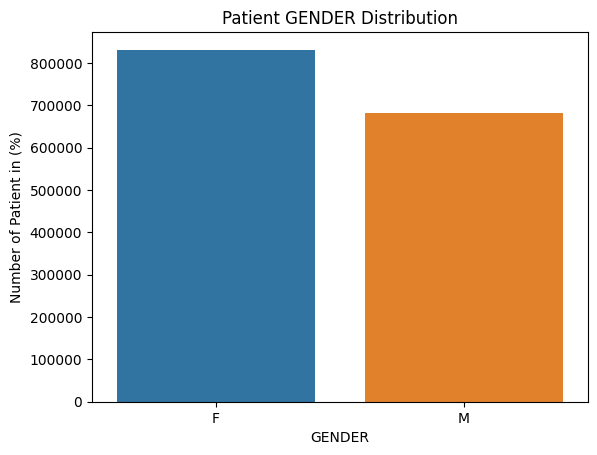

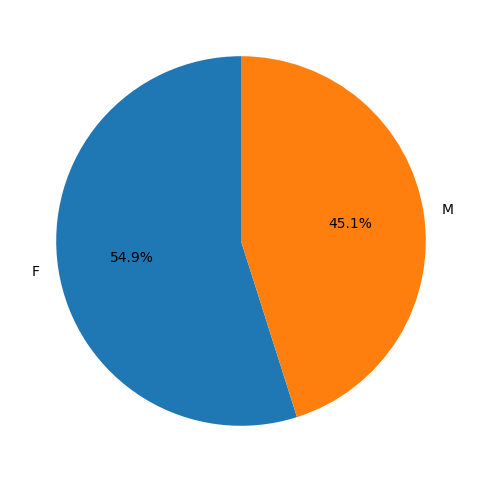

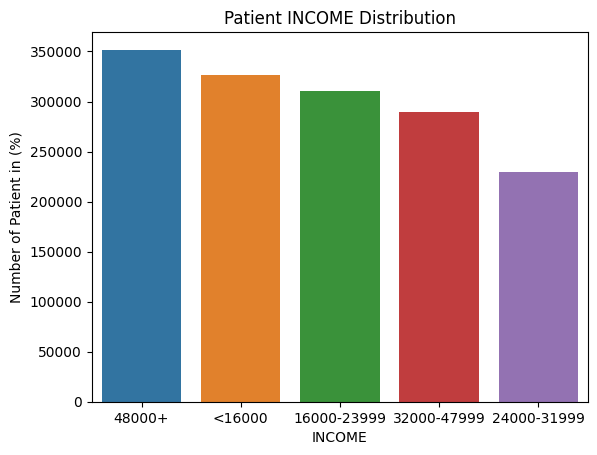

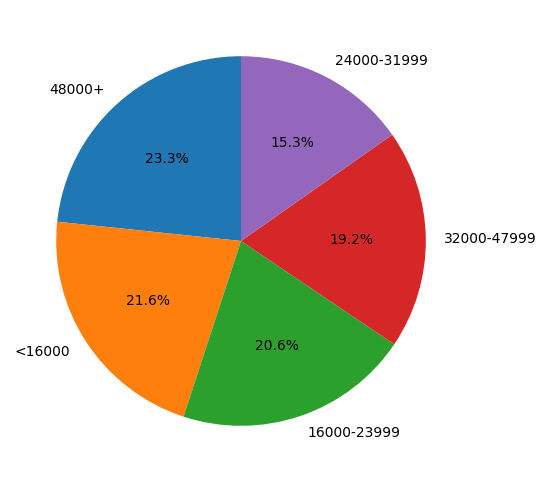

In [21]:
for col in ['AGE',	'GENDER','INCOME']:
    counts = tran_df[col].value_counts()
    sns.barplot(x=counts.index, y=counts.values, hue=counts.index, legend=False)
    plt.xlabel(col)
    plt.ylabel('Number of Patient in (%)')
    plt.title(f'Patient {col} Distribution')
    plt.show()
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.show()


## Correlation Analysis

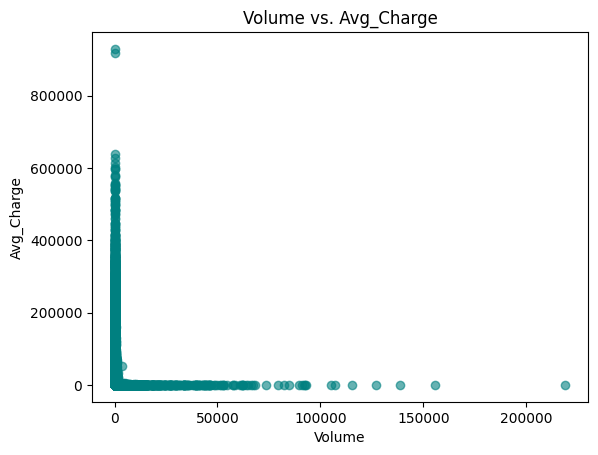

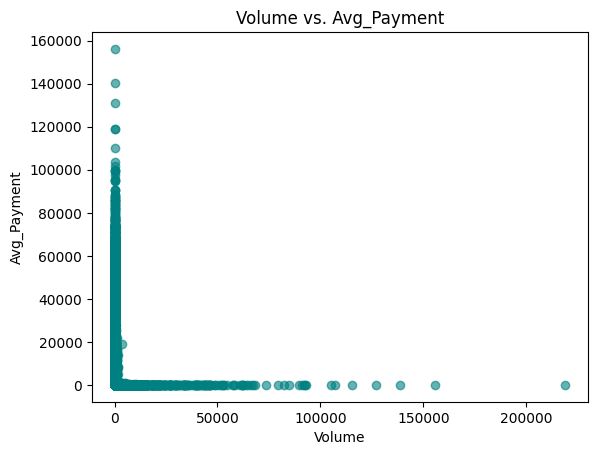

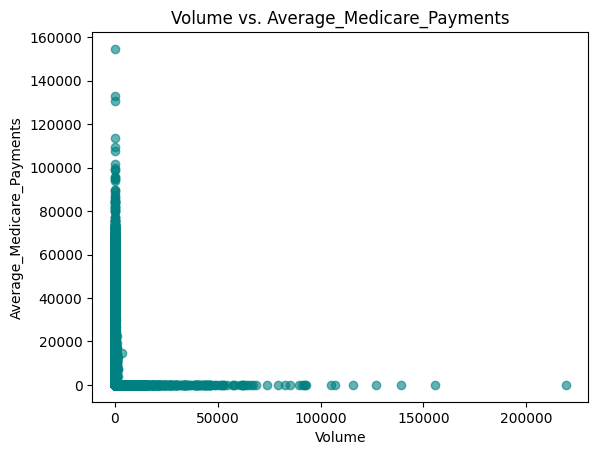

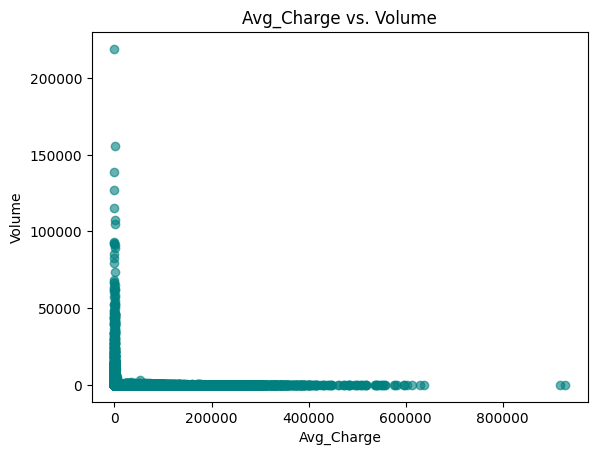

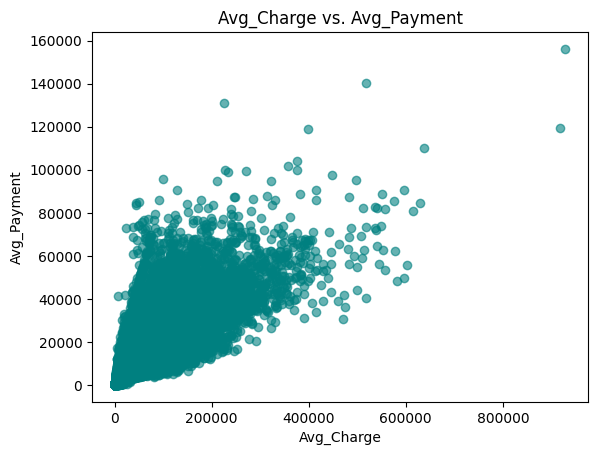

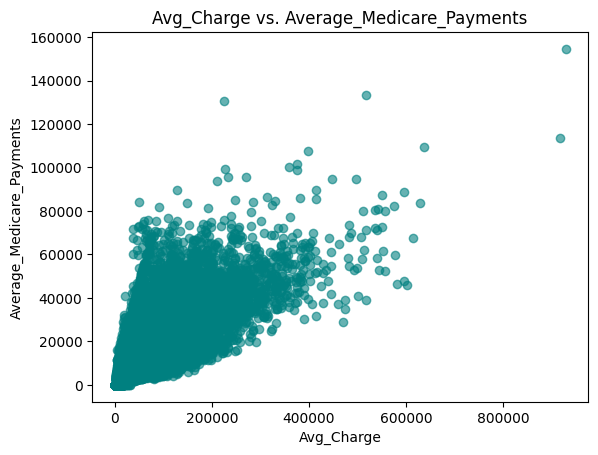

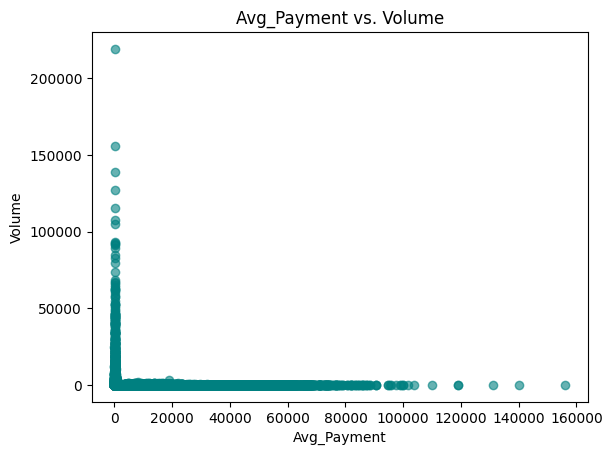

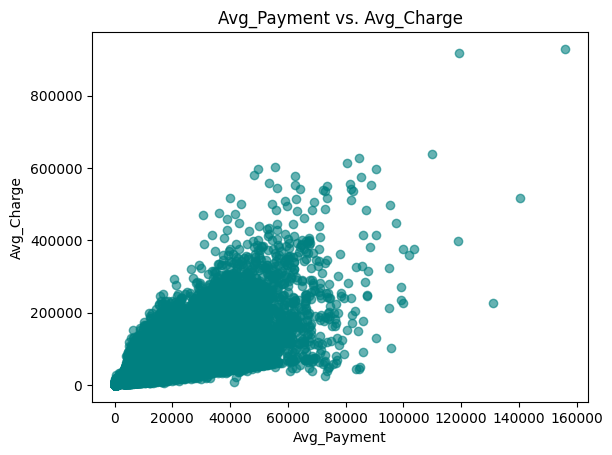

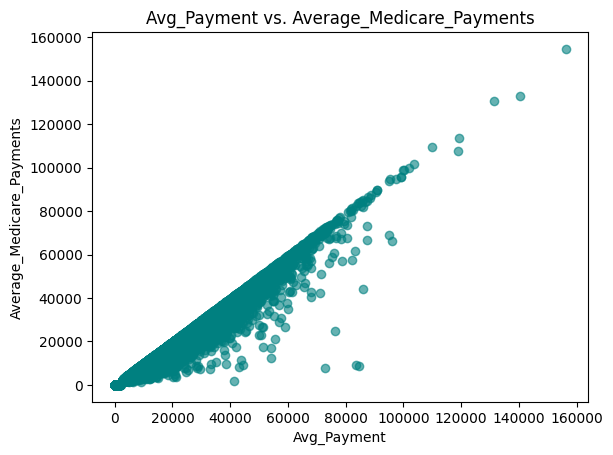

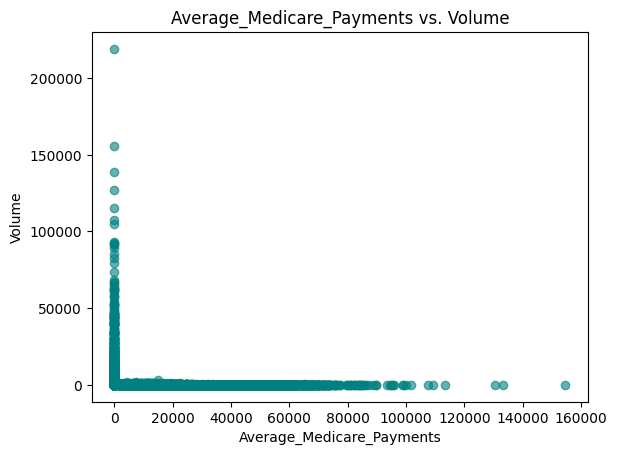

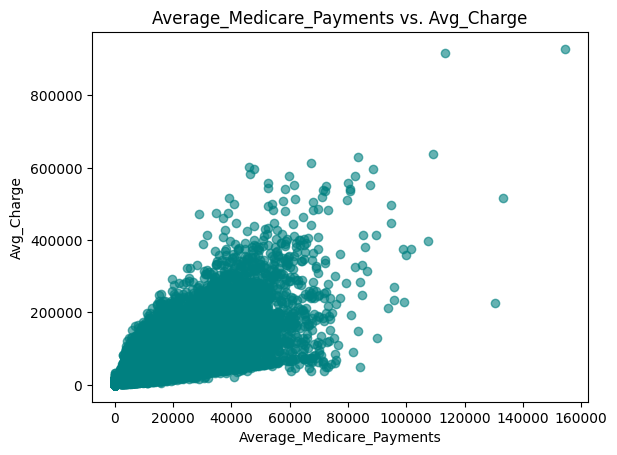

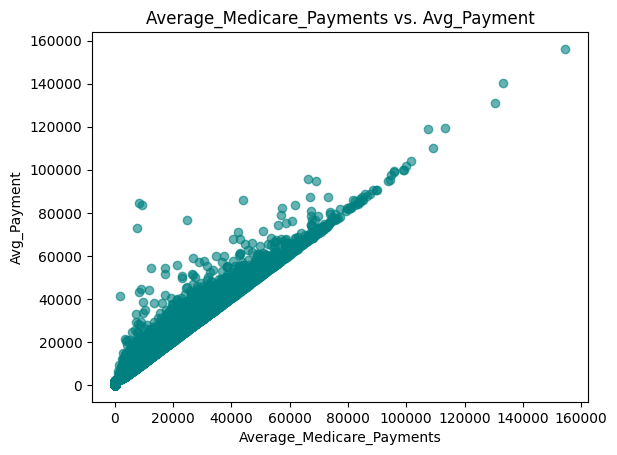

In [22]:
for col1 in ['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']:
    for col2 in  ['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']:
        if col1 != col2:
            plt.scatter(combined_df[col1], combined_df[col2], alpha=0.6, c='teal')
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.title(f'{col1} vs. {col2}')
            plt.show()

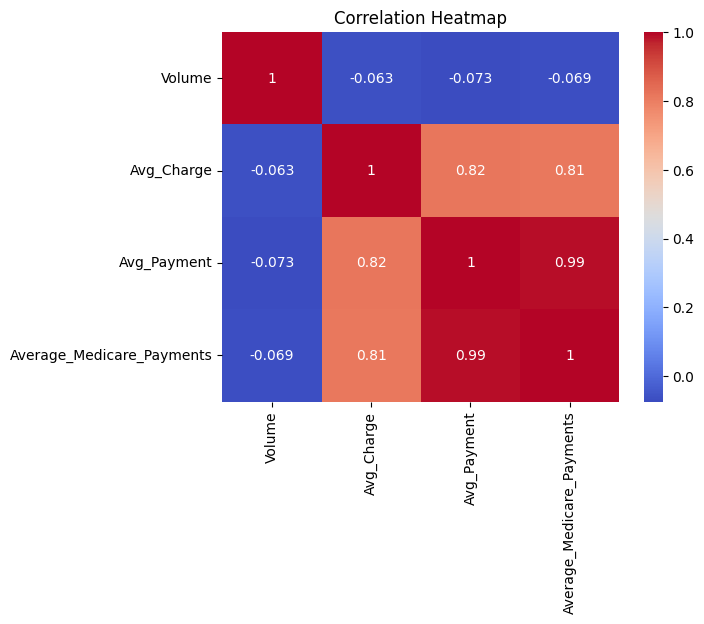

In [23]:
corr = combined_df[['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


## Identify providers that overcharge for certain procedures or regions where procedures are too expensive.    
## Part 1A: Highest Cost Variation 

In [24]:
combined_df = pd.concat([apc_df, drg_df], ignore_index=True)

In [25]:
# Calculate coefficient of variation (CoV) for charges per procedure
cost_variation = drg_sum_df.groupby('Procedure_Code')['Avg_charge'].agg(['mean', 'std', 'count']).reset_index()
cost_variation['CoV'] = cost_variation['std'] / cost_variation['mean']
cost_variation = cost_variation.sort_values(by='CoV', ascending=False)

# Filter procedures with significant variation (CoV > 0.5)
high_variation_procedures = cost_variation[cost_variation['CoV'] > 0.5]
print("Part 1A: Highest Cost Variation Procedures")
high_variation_procedures.head(10)

Part 1A: Highest Cost Variation Procedures


,Procedure_Code,mean,std,count
122,870 - SEPTICEMIA OR SEVERE SEPSIS W MV 96+ HOURS,163227.335838,90553.986069,939
51,207 - RESPIRATORY SYSTEM DIAGNOSIS W VENTILATO...,143428.055193,84817.423416,1163
121,853 - INFECTIOUS & PARASITIC DISEASES W O.R. P...,139186.355013,78280.144525,1376
82,329 - MAJOR SMALL & LARGE BOWEL PROCEDURES W MCC,135330.944075,73833.904752,1476
96,460 - SPINAL FUSION EXCEPT CERVICAL W/O MCC,95568.280611,47129.769483,1332
56,246 - PERC CARDIOVASC PROC W DRUG-ELUTING STEN...,96348.810634,42584.847787,917
60,252 - OTHER VASCULAR PROCEDURES W MCC,83502.961076,41521.314804,1151
97,469 - MAJOR JOINT REPLACEMENT OR REATTACHMENT ...,81704.230798,40188.311331,932
100,480 - HIP & FEMUR PROCEDURES EXCEPT MAJOR JOIN...,75339.618352,38177.074345,929
53,238 - MAJOR CARDIOVASC PROCEDURES W/O MCC,85010.453166,35330.827371,1054


## Parts 1B: Highest-Cost Claims by Provider  

In [26]:
# Rank providers by avg charge for each procedure
provider_cost = combined_df.groupby(['Procedure_Code', 'Provider_Id'])['Avg_Charge'].mean().reset_index()
provider_cost['Rank'] = provider_cost.groupby('Procedure_Code')['Avg_Charge'].rank(ascending=False)

# Top  most expensive providers per procedure
top_expensive_providers = provider_cost[provider_cost['Rank'] == 1]
print("\nPart 1B: Top Expensive Providers per Procedure")
top_expensive_providers.sort_values(by='Rank').head(10)


Part 1B: Top Expensive Providers per Procedure


,Procedure_Code,Provider_Id,Avg_Charge,Rank
157,0012 - Level I Debridement & Destruction,280129,841.900024,1.0
150647,419 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,50367,140449.187500,1.0
150334,418 - LAPAROSCOPIC CHOLECYSTECTOMY W/O C.D.E. ...,390180,173771.578125,1.0
148168,394 - OTHER DIGESTIVE SYSTEM DIAGNOSES W CC,50195,103155.609375,1.0
146740,"392 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",310025,96216.734375,1.0
144729,"391 - ESOPHAGITIS, GASTROENT & MISC DIGEST DIS...",390027,138368.109375,1.0
142931,390 - G.I. OBSTRUCTION W/O CC/MCC,310025,80514.882812,1.0
141336,389 - G.I. OBSTRUCTION W CC,310025,151705.531250,1.0
138956,379 - G.I. HEMORRHAGE W/O CC/MCC,50125,65729.273438,1.0
137733,378 - G.I. HEMORRHAGE W CC,310025,127678.304688,1.0


## Parts 1C: Highest-Cost Claims by Region

In [27]:
# Calculate average charges per region/procedure
region_cost = combined_df.groupby(['Procedure_Code', 'Region'])['Avg_Charge'].mean().reset_index()
region_cost['Rank'] = region_cost.groupby('Procedure_Code')['Avg_Charge'].rank(ascending=False)

# Top  most expensive regions per procedure

top_expensive_regions = region_cost[region_cost['Rank'] == 1]
print("\nPart 1C: Top Expensive Regions per Procedure")
top_expensive_regions.head(10)


Part 1C: Top Expensive Regions per Procedure


,Procedure_Code,Region,Avg_Charge,Rank
93,0012 - Level I Debridement & Destruction,NE - Omaha,438.307058,1.0
160,0013 - Level II Debridement & Destruction,AL - Dothan,1042.707428,1.0
582,0015 - Level III Debridement & Destruction,MI - Dearborn,1478.536560,1.0
756,0019 - Level I Excision/ Biopsy,CA - Los Angeles,15946.325684,1.0
1013,0020 - Level II Excision/ Biopsy,IL - Aurora,15784.974609,1.0
1250,0073 - Level III Endoscopy Upper Airway,NH - Manchester,2167.000000,1.0
1285,0074 - Level IV Endoscopy Upper Airway,CA - Redding,32079.990234,1.0
1517,0078 - Level III Pulmonary Treatment,CA - Santa Rosa,2361.535604,1.0
1838,0096 - Level II Noninvasive Physiologic Studies,FL - Hudson,2385.318400,1.0
2089,0203 - Level IV Nerve Injections,CA - San Mateo County,11036.431641,1.0


## Part 1D: Highest Number of Procedures and Largest Differences between Claims and Reimbursements 

In [28]:
# Calculate charge-to-payment ratio and total procedure volume
procedure_gaps = combined_df.groupby(['Procedure_Code', 'Provider_Id']).agg(
    Total_Volume=('Volume', 'sum'),
    Avg_Charge=('Avg_Charge', 'mean'),
    Avg_Payment=('Avg_Payment', 'mean')
).reset_index()
procedure_gaps['Charge_Payment_Ratio'] = procedure_gaps['Avg_Charge'] / procedure_gaps['Avg_Payment']

# Sort by volume and ratio
high_risk_procedures = procedure_gaps.sort_values(
    by=['Total_Volume', 'Charge_Payment_Ratio'], 
    ascending=[False, False]
)
print("\nPart 1D: High-Risk Procedures (Volume + Payment Gap)")
high_risk_procedures.head(10)


Part 1D: High-Risk Procedures (Volume + Payment Gap)


,Procedure_Code,Provider_Id,Total_Volume,Avg_Charge,Avg_Payment,Charge_Payment_Ratio
37628,0604 - Level 1 Hospital Clinic Visits,360180,219042,67.099098,49.193069,1.363995
40079,0605 - Level 2 Hospital Clinic Visits,450054,155708,135.476013,69.550034,1.947893
38824,0605 - Level 2 Hospital Clinic Visits,140010,138852,89.890411,77.407364,1.161264
36705,0604 - Level 1 Hospital Clinic Visits,140276,127131,68.285210,53.899765,1.266893
39182,0605 - Level 2 Hospital Clinic Visits,220171,115553,96.919212,82.512306,1.174603
41964,0606 - Level 3 Hospital Clinic Visits,450054,107245,175.882065,92.375557,1.903989
39619,0605 - Level 2 Hospital Clinic Visits,340030,104934,198.618759,72.842674,2.726681
37002,0604 - Level 1 Hospital Clinic Visits,220071,93059,82.040672,59.455582,1.379865
37764,0604 - Level 1 Hospital Clinic Visits,390111,92373,77.478378,54.731304,1.415614
39767,0605 - Level 2 Hospital Clinic Visits,360180,91950,84.730453,70.483704,1.202128


## Part 2  Identify the three providers that are least like other providers and the three regions that are least similar to other regions (You can perform this in Python) 



In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
combined_df["Medicare_Reliance"]=combined_df["Average_Medicare_Payments"] / combined_df["Avg_Payment"]

## Part 2A: Providers Least Like Others  

In [31]:
providers = combined_df.groupby('Provider_Id').agg({
    'Avg_Charge': 'mean',
    'Avg_Payment': 'mean',
    'Volume': 'sum',
    "Medicare_Reliance" : "mean"
    
}).reset_index()

In [32]:
# Normalize features
scaler = StandardScaler()
provider_features = scaler.fit_transform(providers[['Avg_Charge', 'Avg_Payment', 'Volume', 'Medicare_Reliance']])

# Calculate pairwise Euclidean distances
distance_matrix = pairwise_distances(provider_features, metric='euclidean')

# Find providers with largest average distance to others
providers['Avg_Distance'] = distance_matrix.mean(axis=1)
outlier_providers = providers.nlargest(3, 'Avg_Distance')

print("Top 3 Outlier Providers by Euclidean Distance:")
print(outlier_providers[['Provider_Id', 'Avg_Charge', 'Avg_Distance']])

Top 3 Outlier Providers by Euclidean Distance:
      Provider_Id     Avg_Charge  Avg_Distance
2785       450054   23142.067752     19.475082
3143       490142  211922.000000     19.141285
2279       360180   37831.169929     18.252783


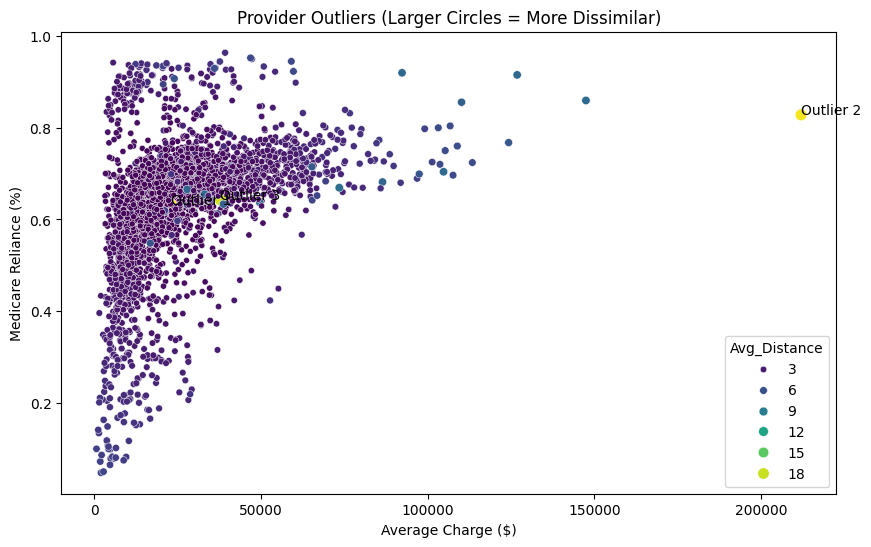

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Avg_Charge',
    y='Medicare_Reliance',
    size='Avg_Distance',
    hue='Avg_Distance',
    data=providers,
    palette='viridis'
)
plt.title('Provider Outliers (Larger Circles = More Dissimilar)')
plt.xlabel('Average Charge ($)')
plt.ylabel('Medicare Reliance (%)')
plt.annotate('Outlier 1', (outlier_providers.iloc[0]['Avg_Charge'], outlier_providers.iloc[0]['Medicare_Reliance']))
plt.annotate('Outlier 2', (outlier_providers.iloc[1]['Avg_Charge'], outlier_providers.iloc[1]['Medicare_Reliance']))
plt.annotate('Outlier 3', (outlier_providers.iloc[2]['Avg_Charge'], outlier_providers.iloc[2]['Medicare_Reliance']))
plt.show()

## Part 2B: Regions Least Like Others

In [34]:
regions = combined_df.groupby('Region').agg({
    'Avg_Charge': 'mean',
    'Avg_Payment': 'mean',
    'Volume': 'sum',
    "Medicare_Reliance" : "mean"
    
}).reset_index()

In [35]:
# Normalize features
scaler = StandardScaler()
region_features = scaler.fit_transform(regions[['Avg_Charge', 'Avg_Payment', 'Volume', 'Medicare_Reliance']])

# Calculate pairwise Euclidean distances
distance_matrix = pairwise_distances(region_features, metric='euclidean')

# Find regions with largest average distance to others
regions['Avg_Distance'] = distance_matrix.mean(axis=1)
outlier_regions = regions.nlargest(3, 'Avg_Distance')

print("Top 3 Outlier Regions by Euclidean Distance:")
print(outlier_regions[['Region', 'Avg_Charge', 'Avg_Distance']])

Top 3 Outlier Regions by Euclidean Distance:
               Region    Avg_Charge  Avg_Distance
127       MA - Boston  16681.153157     10.398962
130    MD - Baltimore  14321.608773      6.602769
132  MD - Takoma Park  13661.835585      6.355083


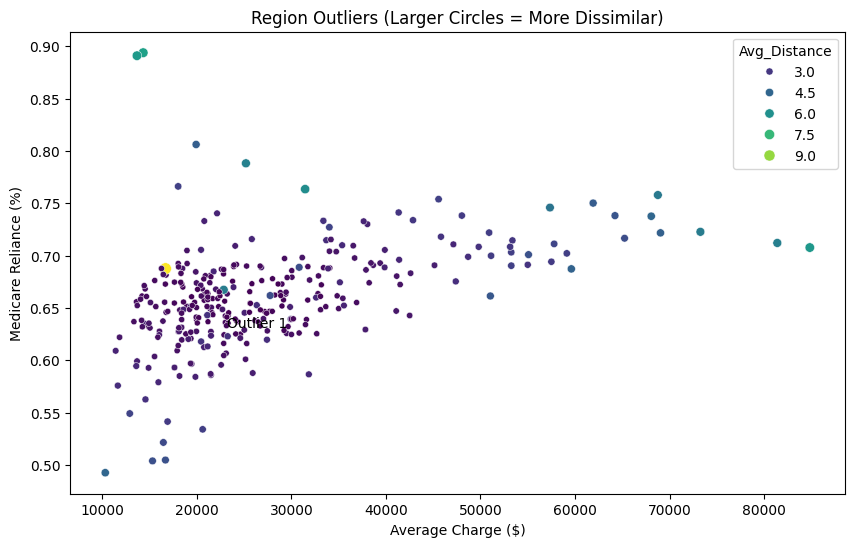

In [36]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='Avg_Charge',
    y='Medicare_Reliance',
    size='Avg_Distance',
    hue='Avg_Distance',
    data=regions,
    palette='viridis'
)
plt.title('Region Outliers (Larger Circles = More Dissimilar)')
plt.xlabel('Average Charge ($)')
plt.ylabel('Medicare Reliance (%)')
plt.annotate('Outlier 1', (outlier_providers.iloc[0]['Avg_Charge'], outlier_providers.iloc[0]['Medicare_Reliance']))
plt.show()

## Part 3: Identify 10,000 Medicare patients who are involved in anomalous activities.  

In [37]:
## relevant  data not available

## Part 4 Predict whether a provider's claim for a specific procedure (DRG) is anomalous, indicating potential fraud or error.

## Anomaly Detection in inpatient data

In [38]:
combined_df=drg_df.copy()

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler



# Select features to use for anomaly detection
features = ['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']
X = combined_df[features].copy()

# Standardize features to ensure each feature contributes equally
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize and fit the Isolation Forest model
# contamination is set to 0.05 assuming about 5% anomalies; adjust as necessary
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_scaled)

# Predict anomalies: returns 1 for normal points and -1 for anomalies
combined_df["anomaly_label"] = iso_forest.predict(X_scaled)

# Get anomaly scores (higher negative scores indicate more anomalous points)
combined_df["anomaly_score"] = iso_forest.decision_function(X_scaled)

# Convert prediction to binary flag: 1 indicates anomaly, 0 indicates normal
combined_df["anomaly"] = np.where(combined_df["anomaly_label"] == -1, 1, 0)


In [40]:
combined_df.to_csv('cleaned.csv')

In [41]:
combined_df

,Procedure_Code,Provider_Id,Provider_Name,Provider_Street_Address,Provider_City,Provider_State,Provider_Zip_Code,Region,Volume,Avg_Charge,Avg_Payment,Average_Medicare_Payments,Type of Service,anomaly_label,anomaly_score,anomaly
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.078125,5777.241699,4763.736328,Inpatient,1,0.066194,0
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.857422,5787.571289,4976.714355,Inpatient,1,0.117979,0
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.375000,5434.958496,4453.791504,Inpatient,1,0.098250,0
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.280273,5417.560059,4129.160156,Inpatient,1,0.126631,0
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.277344,5658.333496,4851.444336,Inpatient,1,0.116314,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.390625,3806.869629,3071.391357,Inpatient,1,0.092675,0
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.726562,4027.363525,2649.727295,Inpatient,1,0.077522,0
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.738281,5704.368652,4058.368408,Inpatient,1,0.100343,0
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.091797,7663.090820,6848.545410,Inpatient,1,0.106678,0


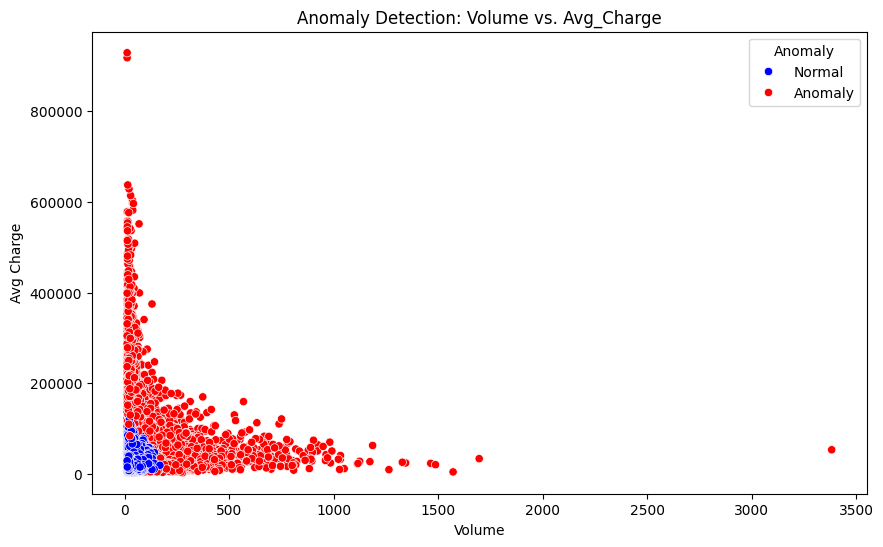

In [42]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, x='Volume', y='Avg_Charge', hue='anomaly',
                 palette={0: 'blue', 1: 'red'})
plt.title('Anomaly Detection: Volume vs. Avg_Charge')
plt.xlabel('Volume')
plt.ylabel('Avg Charge')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, ["Normal", "Anomaly"], title="Anomaly")
plt.show()


In [43]:
combined_df['anomaly'].value_counts()/combined_df.shape[0]*100

anomaly
0    87.782173
1    12.217827
Name: count, dtype: float64

## Classifiaction model on anomaly predicted  by isolation forest

In [44]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import joblib

# Encode Region and Procedure
le_drg = LabelEncoder()
le_hrr = LabelEncoder()
combined_df['Procedure_Code_Encoded'] = le_drg.fit_transform(combined_df['Procedure_Code'])
combined_df['Region_Encoded'] = le_hrr.fit_transform(combined_df['Region'])

joblib.dump(le_drg, 'drg_enc.pkl')

joblib.dump(le_hrr, 'region_enc.pkl')

# Select features
features = ['Procedure_Code_Encoded', 'Region_Encoded', "Volume", "Avg_Charge","Avg_Payment","Average_Medicare_Payments"	]
X = combined_df[features]
y = combined_df['anomaly']

# data is split in a stratified fashion, using this as the class labels.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Train model  
# Balancing of positive and negative weights.
model = XGBClassifier(scale_pos_weight=sum(y_train==0)/sum(y_train==1))
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [45]:
y_pred = model.predict(X_test)

In [46]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9947260294974397
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28628
           1       0.97      0.99      0.98      3985

    accuracy                           0.99     32613
   macro avg       0.98      0.99      0.99     32613
weighted avg       0.99      0.99      0.99     32613



In [47]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(class_weight='balanced')
model2.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [48]:
y_pred = model2.predict(X_test)

In [49]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9949713304510471
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28628
           1       0.99      0.97      0.98      3985

    accuracy                           0.99     32613
   macro avg       0.99      0.99      0.99     32613
weighted avg       0.99      0.99      0.99     32613



## Random Forest is Selected for deployment due to high precision

In [50]:
joblib.dump(model2, 'model.pkl')

['model.pkl']

In [51]:
from sklearn.linear_model  import LogisticRegression
model3 = LogisticRegression(class_weight='balanced')
model3.fit(X_train, y_train)

C:\Users\faiza\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced')

In [52]:
y_pred = model3.predict(X_test)

In [53]:
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7817128139085641
              precision    recall  f1-score   support

           0       0.98      0.76      0.86     28628
           1       0.35      0.91      0.50      3985

    accuracy                           0.78     32613
   macro avg       0.67      0.83      0.68     32613
weighted avg       0.91      0.78      0.82     32613



## Segmentation Analysis for inpatient data

In [54]:
combined_df=drg_df.copy()

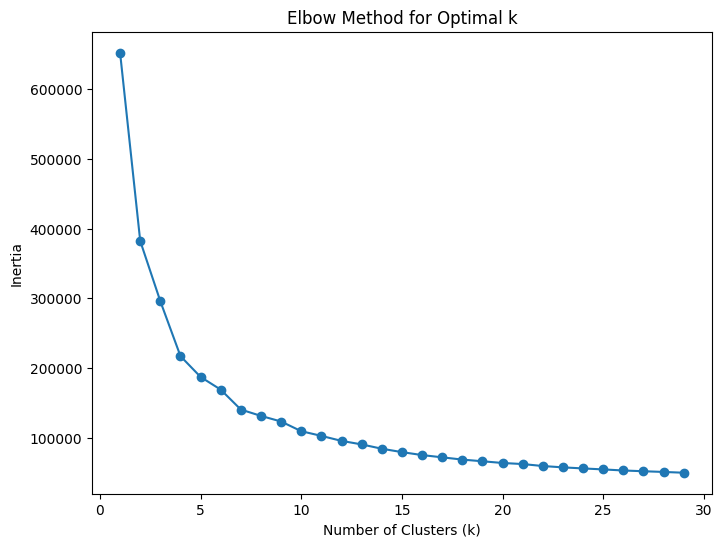

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Select features for clustering
features = ['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']
X = combined_df[features].dropna()

# Standardize features so that each contributes equally
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X))

# Apply kmeans for different numbers of k
inertia_values = []
k_values = range(1, 30, 1)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

             Volume     Avg_Charge   Avg_Payment  Average_Medicare_Payments
cluster                                                                    
0        202.627618   32518.391770   9065.044800                7795.208580
1         35.345948   50530.631815  12710.635636               11383.887189
2         27.127529  191150.389876  46158.768797               43267.490549
3         31.284786   95479.419233  25606.521644               23504.540271
4         34.387713   20782.581021   6035.817475                5004.921002


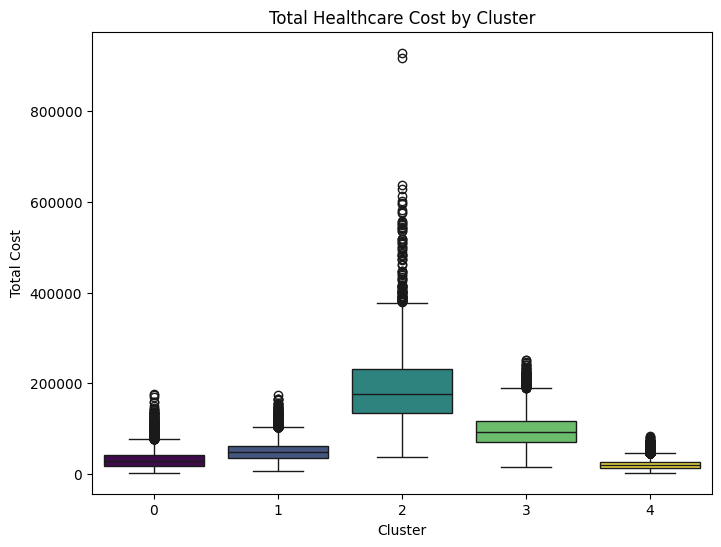

In [56]:
k = 5  
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
combined_df['cluster'] = clusters

# Compare healthcare outcomes (e.g., total_cost) across clusters
cluster_summary = combined_df.groupby('cluster')[['Volume','Avg_Charge','Avg_Payment','Average_Medicare_Payments']].mean()
print(cluster_summary)

# Visualize cost differences with a box plot
plt.figure(figsize=(8,6))
sns.boxplot(x='cluster', y='Avg_Charge', data=combined_df, hue='cluster',legend=False,palette='viridis')
plt.title("Total Healthcare Cost by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Total Cost")
plt.show()

In [57]:
combined_df['cluster'].value_counts()/combined_df.shape[0]*100

cluster
4    62.779873
1    24.259038
3     6.227578
0     5.036029
2     1.697483
Name: count, dtype: float64

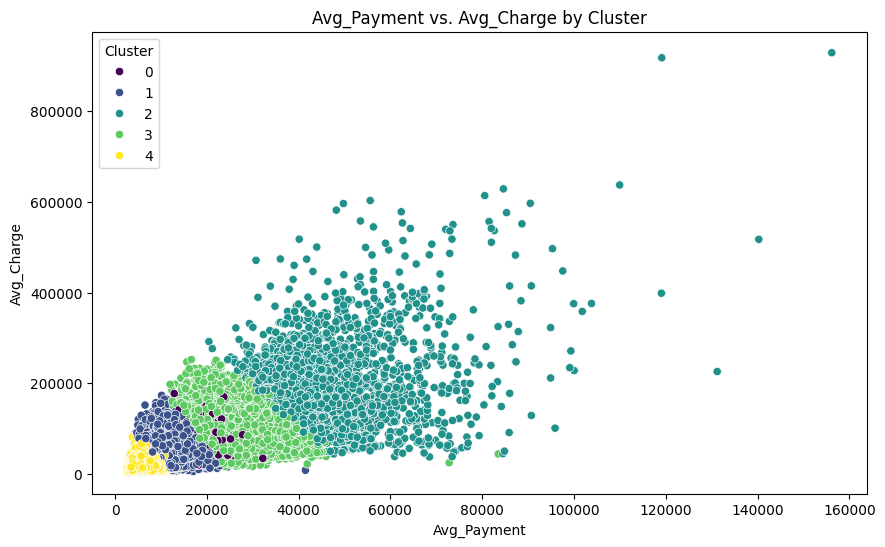

In [58]:
# Visualize cost differences with a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=combined_df, 
                x='Avg_Payment', 
                y='Avg_Charge', 
                hue='cluster', 
                palette='viridis')
plt.title("Avg_Payment vs. Avg_Charge by Cluster")
plt.xlabel("Avg_Payment")
plt.ylabel("Avg_Charge")
plt.legend(title="Cluster")
plt.show()
